## High-dimensional dynamics of generalization error in neural networks

Attempt to reproduce Figure 5B in the paper and reproduce double descent.


In [1]:
#!/usr/bin/env python
# coding: utf-8

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d

import argparse
import os
import datetime
import pathlib
import random
import json
import numpy as np
import math

import torch


import sys
sys.path.append('../code/')
from linear_utils import linear_model, get_modulation_matrix
from train_utils import save_config

In [16]:
# argument written in command line format
cli_args = '--seed 12 --save-results --risk-loss L2 -t 50000 -w 1 1 --lr 0.001 0.0001 -d 10 -n 100 --hidden 50 --sigmas 1 --kappa 3.0'
sigma_noise = 1.0
transform_data = True
cont_eigs = False

#cli_args = '--seed 12 --save-results --jacobian --risk-loss L2 -t 20000 -w 0.1 0.1 --lr 0.00001 -d 50 -n 1000 --hidden 50 --sigmas 1 --kappa 3'
#sigma_noise = 1.0



In [3]:
"""
A fully-connected network with one hidden layer, trained to predict y from x
by minimizing the MSE loss.
"""

# get CLI parameters
parser = argparse.ArgumentParser(description='CLI parameters for training')
parser.add_argument('--root', type=str, default='', metavar='DIR',
                    help='Root directory')
parser.add_argument('-t', '--iterations', type=int, default=1e4, metavar='ITERATIONS',
                    help='Iterations (default: 1e4)')
parser.add_argument('-n', '--samples', type=int, default=100, metavar='N',
                    help='Number of samples (default: 100)')
parser.add_argument('--print-freq', type=int, default=1000,
                    help='CLI output printing frequency (default: 1000)')
parser.add_argument('--gpu', type=int, default=None,
                    help='Number of GPUS to use')
parser.add_argument('--seed', type=int, default=None,
                    help='Random seed')                        
parser.add_argument('-d', '--dim', type=int, default=50, metavar='DIMENSION',
                    help='Feature dimension (default: 50)')
parser.add_argument('--hidden', type=int, default=200, metavar='DIMENSION',
                    help='Hidden layer dimension (default: 200)')
parser.add_argument('--sigmas', type=str, default=None,
                    help='Sigmas')     
parser.add_argument('-r','--s-range', nargs='*', type=float,
                    help='Range for sigmas')
parser.add_argument('--kappa', type=float,
                    help='Eigenvalue ratio')
parser.add_argument('-w','--scales', nargs='*', type=float,
                    help='scale of the weights')
parser.add_argument('--lr', type=float, default=1e-4, nargs='*', metavar='LR',
                    help='learning rate (default: 1e-4)')              
parser.add_argument('--normalized', action='store_true', default=False,
                    help='normalize sample norm across features')
parser.add_argument('--risk-loss', type=str, default='MSE', metavar='LOSS',
                    help='Loss for validation')
parser.add_argument('--jacobian', action='store_true', default=False,
                    help='compute the SVD of the jacobian of the network')
parser.add_argument('--save-results', action='store_true', default=False,
                    help='Save the results for plots')
parser.add_argument('--details', type=str, metavar='N',
                    default='no_detail_given',
                    help='details about the experimental setup')


args = parser.parse_args(cli_args.split())

# directories
root = pathlib.Path(args.root) if args.root else pathlib.Path.cwd().parent

current_date = str(datetime.datetime.today().strftime('%Y-%m-%d-%H-%M-%S'))
args.outpath = (pathlib.Path.cwd().parent / 'results' / 'two_layer_nn' /  current_date)

if args.save_results:
    args.outpath.mkdir(exist_ok=True, parents=True)

if args.seed is not None:
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    
device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

In [5]:
p = int(np.ceil(args.dim / 2))
#k = args.kappa
#F = get_modulation_matrix(args.dim, p, k)

beta = np.ones((args.dim,))

# Set to False if you want to transform after data sampling
scale_beta=True

d_out = 1      # dimension of y

# sample training set from the linear model
lin_model = linear_model(args.dim, sigma_noise=sigma_noise, beta=beta, scale_beta=scale_beta, normalized=False, sigmas=args.sigmas, s_range=args.s_range, coupled_noise=False, transform_data=transform_data, kappa=args.kappa, p=p, cont_eigs=cont_eigs, masked_input=False)
Xs, ys = lin_model.sample(args.samples, train=True)

# sample the set for empirical risk calculation
Xt, yt = lin_model.sample(args.samples, train=False) # 1000
beta = lin_model.beta

[3. 3. 3. 3. 3. 1. 1. 1. 1. 1.]
[[ 0.00000000e+00  2.22744749e-02 -5.24598003e-01 -2.97619625e-01
   7.97322608e-01 -1.31771236e-17  3.19571144e-16 -1.17462915e-16
   3.75457402e-17 -1.20817228e-16]
 [ 0.00000000e+00 -7.11380922e-01 -4.30619887e-01 -3.79847846e-01
  -4.05239819e-01  4.64752392e-16  1.25942501e-17  1.60223967e-16
  -2.42482860e-16 -8.58250399e-17]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  5.86868488e-01 -1.91411363e-02 -7.48422292e-01
  -3.08355425e-01  3.12352401e-16  1.88836278e-17 -4.91845568e-17
   9.54788201e-18 -1.52028259e-17]
 [-0.00000000e+00  3.86039389e-01 -7.34164195e-01  4.54974994e-01
  -3.23997344e-01  1.35096007e-17 -8.59904455e-17 -6.29055573e-17
  -5.87437028e-17 -1.08066593e-16]
 [ 0.00000000e+00  2.66032031e-17 -1.89405979e-16 -6.31990759e-17
   2.77351003e-16  5.51293135e-02 -5.25874981e-01  3.03300111e-01
 

In [6]:
# Transform data (masking)


# Uncomment if you want to transform after data sampling
#Xs = Xs @ F
#Xt = Xt @ F

#_, Ss, Vh = np.linalg.svd(Xs)
#_, St, _ = np.linalg.svd(np.transpose(Xt) @ Xt)

#print("train")
#print(Ss)
#print("test")
#print(St)

# Uncomment if you transform_data=False, but you want to decouple features
#Xs = Xs @ np.transpose(Vh)
#Xt = Xt @ np.transpose(Vh)

#beta = np.linalg.inv(F) @ beta


In [7]:
Xs = torch.tensor(Xs, dtype=torch.float32).to(device)
ys = torch.tensor(ys.reshape((-1,1)), dtype=torch.float32).to(device)

Xt = torch.tensor(Xt, dtype=torch.float32).to(device)
yt = torch.tensor(yt.reshape((-1,1)), dtype=torch.float32).to(device)

In [8]:
# define loss functions
loss_fn = torch.nn.MSELoss(reduction='sum')
risk_fn = torch.nn.L1Loss(reduction='mean') if args.risk_loss == 'L1' else torch.nn.MSELoss(reduction='sum')

### Empirical

In [ ]:
model = torch.nn.Sequential(
           torch.nn.Linear(args.dim, args.hidden, bias=False),
           # torch.nn.ReLU(),
           torch.nn.Linear(args.hidden, d_out, bias=False),
         ).to(device)      
                
# use kaiming initialization                
if args.scales:
    i = 0
    with torch.no_grad():
        for m in model:
            if type(m) == torch.nn.Linear:
                if i == 0:
                    torch.nn.init.kaiming_normal_(m.weight, a=math.sqrt(5))
                    m.weight.data = torch.mul(m.weight.data, args.scales[0])
                if i == 1:
                    torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                    m.weight.data = torch.mul(m.weight.data, args.scales[1])
                i += 1
                

# use same learning rate for the two layers
#if isinstance(args.lr, list):
#    stepsize = [max(args.lr)] * 2
stepsize = args.lr

In [ ]:
# train the network
losses_emp = []
risks_emp = []
mse_weights_emp = []
for t in range(int(args.iterations)):
    y_pred = model(Xs)

    loss = loss_fn(y_pred, ys)
    losses_emp.append(loss.item())

    if not t % args.print_freq:
        print(t, loss.item())

    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        i = 0
        w_tot = torch.diag(torch.ones(args.dim)) #[]
        for param in model.parameters():
            param.data -= stepsize[i] * param.grad
            #w_tot.append(param.data.t().numpy().copy().reshape(1, -1)) #
            w_tot = w_tot @ param.data.t()
            
            if len(param.shape) > 1:
                i += 1
                
        
        #w_tot = np.column_stack(w_tot)
        w_tot = w_tot.squeeze()
        assert w_tot.shape == beta.shape
        mse_weights_emp.append(((w_tot.numpy()-beta) / beta)**2) #w_tot
                
            
    with torch.no_grad():
        yt_pred = model(Xt)
        
        risk = risk_fn(yt_pred, yt)
        risks_emp.append(risk.item())

        if not t % args.print_freq:
            print(t, risk.item())

In [ ]:
geo_samples = [int(i) for i in np.geomspace(1, len(risks_emp)-1, num=700)]

In [ ]:
risks = np.array(risks_emp)
losses = np.array(losses_emp)
risks_w = np.row_stack(mse_weights_emp)

cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000), cmap(700/1000)]
labelList = ['empirical', 'theoretical']

plot_all_dims = True

extra_axs = 0
if plot_all_dims:
    extra_axs = risks_w.shape[-1] #args.dim

fig, ax = plt.subplots(3 + extra_axs, 1, figsize=(12,12 + 4 * extra_axs))

ax[0].set_xscale('log')
ax[0].plot(geo_samples, risks[geo_samples], 
        color=colorList[1], 
        label=labelList[0],
        lw=4)

ax[0].legend(loc=1, bbox_to_anchor=(1, 1), fontsize='x-large',
    frameon=False, fancybox=True, shadow=True, ncol=1)
ax[0].set_ylabel('risk')
ax[0].set_xlabel(r'$t$ iterations')

ax[1].set_xscale('log')
ax[1].plot(geo_samples, losses[geo_samples], 
        color=colorList[1], 
        label=labelList[0],
        lw=4)

ax[1].set_ylabel('loss')
ax[1].set_xlabel(r'$t$ iterations')

if plot_all_dims:
    for i in range(risks_w.shape[-1]):
        ax[2+i].set_xscale('log')
        ax[2+i].plot(geo_samples, risks_w[geo_samples, i], 
                color=colorList[2], 
                label=labelList[0],
                lw=4)

        ax[2+i].set_ylabel('MSE weights, ' + str(i))
        ax[2+i].set_xlabel(r'$t$ iterations')


ax[-1].set_xscale('log')
ax[-1].plot(geo_samples, risks_w[geo_samples, :].mean(axis=-1), 
        color=colorList[2], 
        label=labelList[0],
        lw=4)

ax[-1].set_ylabel('MSE weights')
ax[-1].set_xlabel(r'$t$ iterations')


plt.show()

In [ ]:
risks = np.array(risks_emp)
losses = np.array(losses_emp)
risks_w = np.row_stack(mse_weights_emp)

cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000), cmap(700/1000)]
labelList = ['empirical', 'theoretical']

extra_axs = 2
fig, ax = plt.subplots(3 + extra_axs, 1, figsize=(12,12 + 4 * extra_axs))

ax[0].set_xscale('log')
ax[0].plot(geo_samples, risks[geo_samples], 
        color=colorList[1], 
        label=labelList[0],
        lw=4)

ax[0].legend(loc=1, bbox_to_anchor=(1, 1), fontsize='x-large',
    frameon=False, fancybox=True, shadow=True, ncol=1)
ax[0].set_ylabel('risk')
ax[0].set_xlabel(r'$t$ iterations')

ax[1].set_xscale('log')
ax[1].plot(geo_samples, losses[geo_samples], 
        color=colorList[1], 
        label=labelList[0],
        lw=4)

ax[1].set_ylabel('loss')
ax[1].set_xlabel(r'$t$ iterations')

p = int(args.dim / 2)
ax[2].set_xscale('log')
ax[2].plot(geo_samples, risks_w[geo_samples, :p].mean(axis=-1), 
        color=colorList[2], 
        label=labelList[0],
        lw=4)

ax[2].set_ylabel('MSE weights, large')
ax[2].set_xlabel(r'$t$ iterations')

ax[3].set_xscale('log')
ax[3].plot(geo_samples, risks_w[geo_samples, p:].mean(axis=-1), 
        color=colorList[2], 
        label=labelList[0],
        lw=4)

ax[3].set_ylabel('MSE weights, small')
ax[3].set_xlabel(r'$t$ iterations')


ax[-1].set_xscale('log')
ax[-1].plot(geo_samples, risks_w[geo_samples, :].mean(axis=-1), 
        color=colorList[2], 
        label=labelList[0],
        lw=4)

ax[-1].set_ylabel('MSE weights')
ax[-1].set_xlabel(r'$t$ iterations')


ax[0].set_ylim([9, 13])
ax[1].set_ylim([80, 105])
ax[2].set_ylim([1, 2.55])
ax[3].set_ylim([0.35, 1.05])
ax[4].set_ylim([1, 1.6])


plt.show()

In [ ]:
fig, ax  = plt.subplots()
plt.plot(risks_emp[:200])

## Theoretical 

In [9]:
# With actual input data
def dt(u, z, S, St):
    assert S.shape == z.shape
    return (St - u * z * S)


def dzdt(u, z, S, St):
    return u * dt(u, z, S, St)


def dudt(u, z, S, St):
    return (dt(u, z, S, St) @ z.T).squeeze()


# Sampling only noise in output (and assuming that we know the true weights)
def dt_s(u, z, S, beta, eps):
    assert S.shape == z.shape
    return (beta - u * z) * S + eps * S**0.5


def dzdt_s(u, z, S, beta, eps):
    return u * dt_s(u, z, S, beta, eps)


def dudt_s(u, z, S, beta, eps):
    return (dt_s(u, z, S, beta, eps) @ z.T).squeeze()


In [10]:
# For the sake of not messing anything up
Xs_t, ys_t, Xt_t, yt_t = Xs.T, ys.T, Xt.T, yt.T

if transform_data:
    V = np.eye(args.dim)
    Uh = np.transpose(lin_model.right_singular_vecs)
    _, s, _ = np.linalg.svd(Xs_t.numpy(), full_matrices=True)
else:
    V, s, Uh = np.linalg.svd(Xs_t.numpy(), full_matrices=True)

V_tensor, Uh_tensor = torch.tensor(V, dtype=torch.float32), torch.tensor(Uh, dtype=torch.float32)
S = torch.tensor(np.concatenate((s**2, np.zeros(args.dim - s.shape[0]))).reshape(1, -1), dtype=torch.float32)
St = ys_t @ Xs_t.T @ V_tensor

#eps_tensor = (torch.randn(size=(1, args.dim)) * sigma_noise)# @ torch.tensor(Uh).T)[:, :args.dim]).reshape(1, -1) #OBS: nu beror denna av input också

beta_tensor = torch.tensor(beta, dtype=torch.float32).reshape(1, -1)
eps_tensor = ((ys_t - beta_tensor @ Xs_t) @ Uh_tensor.T)[:, :args.dim]

In [64]:
# Simulation
w_init = args.scales[0] * 0.1 
u = torch.normal(0, torch.tensor(w_init))
z = torch.normal(0, torch.tensor(w_init), size=(1, args.dim))
print(u)
print(z)

u_track, z_track = [], []
u_track.append(u)
z_track.append(z)

losses_teo = []
risks_teo = []
mse_weights_teo = []

for t in range(int(args.iterations)):
    
    u = 5 #u + args.lr[1] * dudt_s(u_track[-1], z_track[-1], S, beta_tensor, eps_tensor) #dudt(u, z, S, St)
    z = z + args.lr[0] * dzdt_s(u_track[-1], z_track[-1], S, beta_tensor, eps_tensor) #dzdt(u, z, S, St) 
    #u = (S.max() - S.min()) * z.mean()
    
    u_track.append(u)
    z_track.append(z)
    
    Wtot = u * z @ V_tensor.T

    y_pred = Wtot @ Xs_t

    loss = loss_fn(y_pred.T, ys_t.T)
    losses_teo.append(loss.item())

    mse_weights_teo.append((((Wtot.squeeze()-beta_tensor.squeeze()) / beta_tensor.squeeze())**2))

    if not t % args.print_freq:
        print(t, loss.item())
        
    yt_pred = Wtot @ Xt_t

    risk = risk_fn(yt_pred.T, yt_t.T)
    risks_teo.append(risk.item())

    if not t % args.print_freq:
        print(t, risk.item())

tensor(0.0947)
tensor([[ 0.0362, -0.0186,  0.0184, -0.0083, -0.0432, -0.0164,  0.1139, -0.0788,
         -0.0307, -0.0831]])
0 104.9556884765625
0 12.519216537475586
1000 89.36837005615234
1000 11.391010284423828
2000 89.36837005615234
2000 11.391010284423828
3000 89.36837005615234
3000 11.391010284423828
4000 89.36837005615234
4000 11.391010284423828
5000 89.36837005615234
5000 11.391010284423828
6000 89.36837005615234
6000 11.391010284423828
7000 89.36837005615234
7000 11.391010284423828
8000 89.36837005615234
8000 11.391010284423828
9000 89.36837005615234
9000 11.391010284423828
10000 89.36837005615234
10000 11.391010284423828
11000 89.36837005615234
11000 11.391010284423828
12000 89.36837005615234
12000 11.391010284423828
13000 89.36837005615234
13000 11.391010284423828
14000 89.36837005615234
14000 11.391010284423828
15000 89.36837005615234
15000 11.391010284423828
16000 89.36837005615234
16000 11.391010284423828
17000 89.36837005615234
17000 11.391010284423828
18000 89.3683700561

In [65]:
geo_samples = [int(i) for i in np.geomspace(1, len(risks_teo)-1, num=700)]

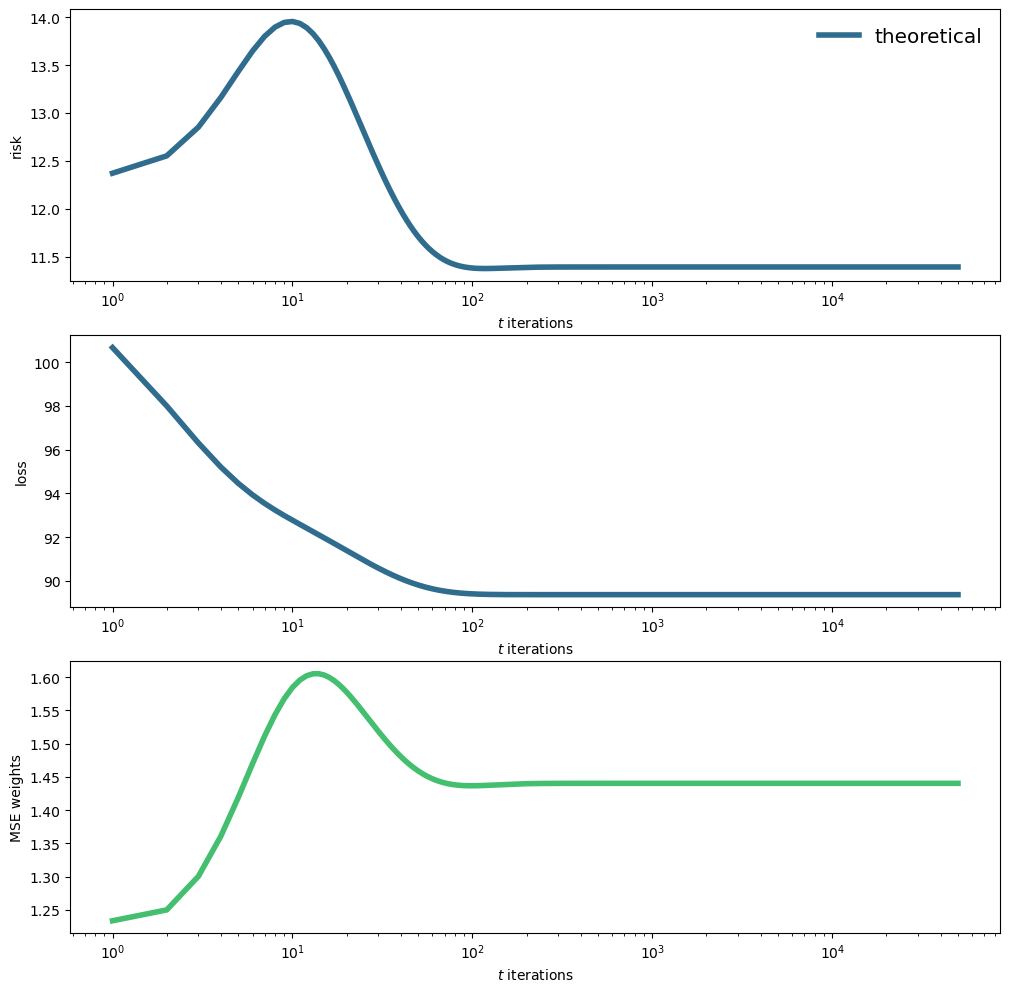

In [66]:
risks = np.array(risks_teo)
losses = np.array(losses_teo)
risks_w = np.row_stack(mse_weights_teo)

cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000), cmap(700/1000)]
labelList = ['empirical', 'theoretical']

plot_all_dims = False

extra_axs = 0
if plot_all_dims:
    extra_axs = args.dim

fig, ax = plt.subplots(3 + extra_axs, 1, figsize=(12,12 + 4 * extra_axs))
ax[0].set_xscale('log')

ax[0].plot(geo_samples, risks[geo_samples], 
        color=colorList[1], 
        label=labelList[1],
        lw=4)

ax[0].legend(loc=1, bbox_to_anchor=(1, 1), fontsize='x-large',
    frameon=False, fancybox=True, shadow=True, ncol=1)
ax[0].set_ylabel('risk')
ax[0].set_xlabel(r'$t$ iterations')

ax[1].set_xscale('log')
ax[1].plot(geo_samples, losses[geo_samples], 
        color=colorList[1], 
        label=labelList[1],
        lw=4)

ax[1].set_ylabel('loss')
ax[1].set_xlabel(r'$t$ iterations')

if plot_all_dims:
    for i in range(args.dim):
        ax[2+i].set_xscale('log')
        ax[2+i].plot(geo_samples, risks_w[geo_samples, i], 
                color=colorList[2], 
                label=labelList[1],
                lw=4)

        ax[2+i].set_ylabel('MSE weights, ' + str(i))
        ax[2+i].set_xlabel(r'$t$ iterations')


ax[-1].set_xscale('log')
ax[-1].plot(geo_samples, risks_w[geo_samples, :].mean(axis=-1), 
        color=colorList[2], 
        label=labelList[1],
        lw=4)

ax[-1].set_ylabel('MSE weights')
ax[-1].set_xlabel(r'$t$ iterations')


plt.show()

Text(0.5, 0, '$t$ iterations')

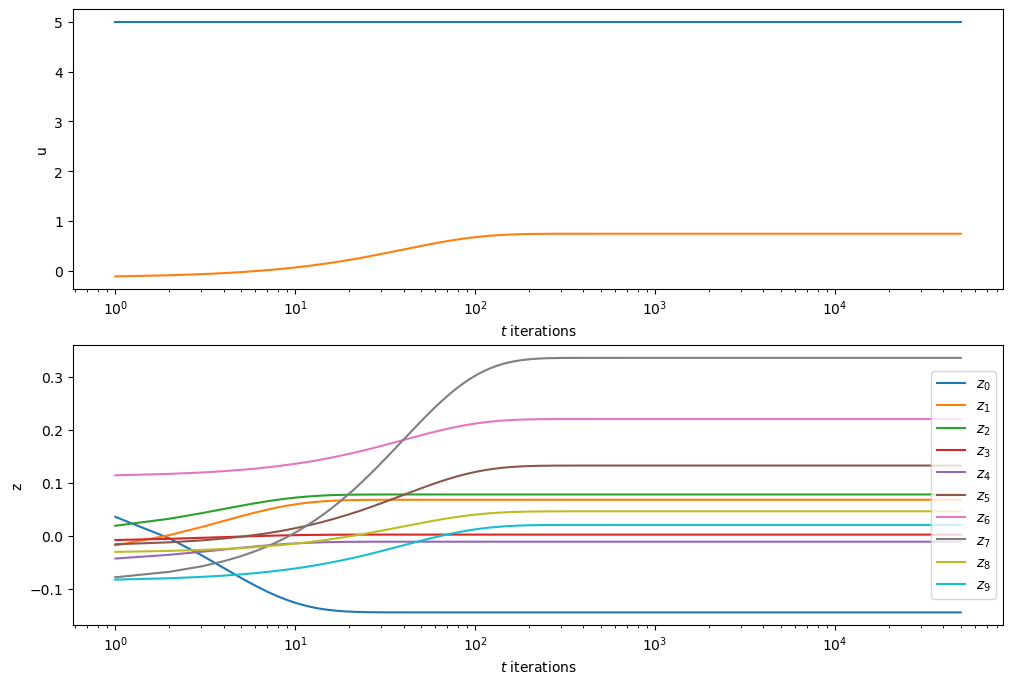

In [67]:
u_track = np.array(u_track)
z_track = np.row_stack(z_track)

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].set_xscale('log')
ax[0].plot(geo_samples, u_track[geo_samples], label="u")
#ax[0].plot(geo_samples, risks_w[geo_samples, :].mean(axis=-1), label="risk")
ax[0].set_ylabel('u')
ax[0].set_xlabel(r'$t$ iterations')

ax[0].plot(geo_samples, z_track[geo_samples, :].sum(axis=-1))
#ax[0].plot(geo_samples, losses[geo_samples] )

ax[1].set_xscale('log')
for i in range(args.dim):
    ax[1].plot(geo_samples, z_track[geo_samples, i], label=fr"$z_{i}$")
    
ax[1].legend()
ax[1].set_ylabel('z')
ax[1].set_xlabel(r'$t$ iterations')

# Interaktionen ökar med tiden? Trenden följer lossen (eller lossen följer u)?


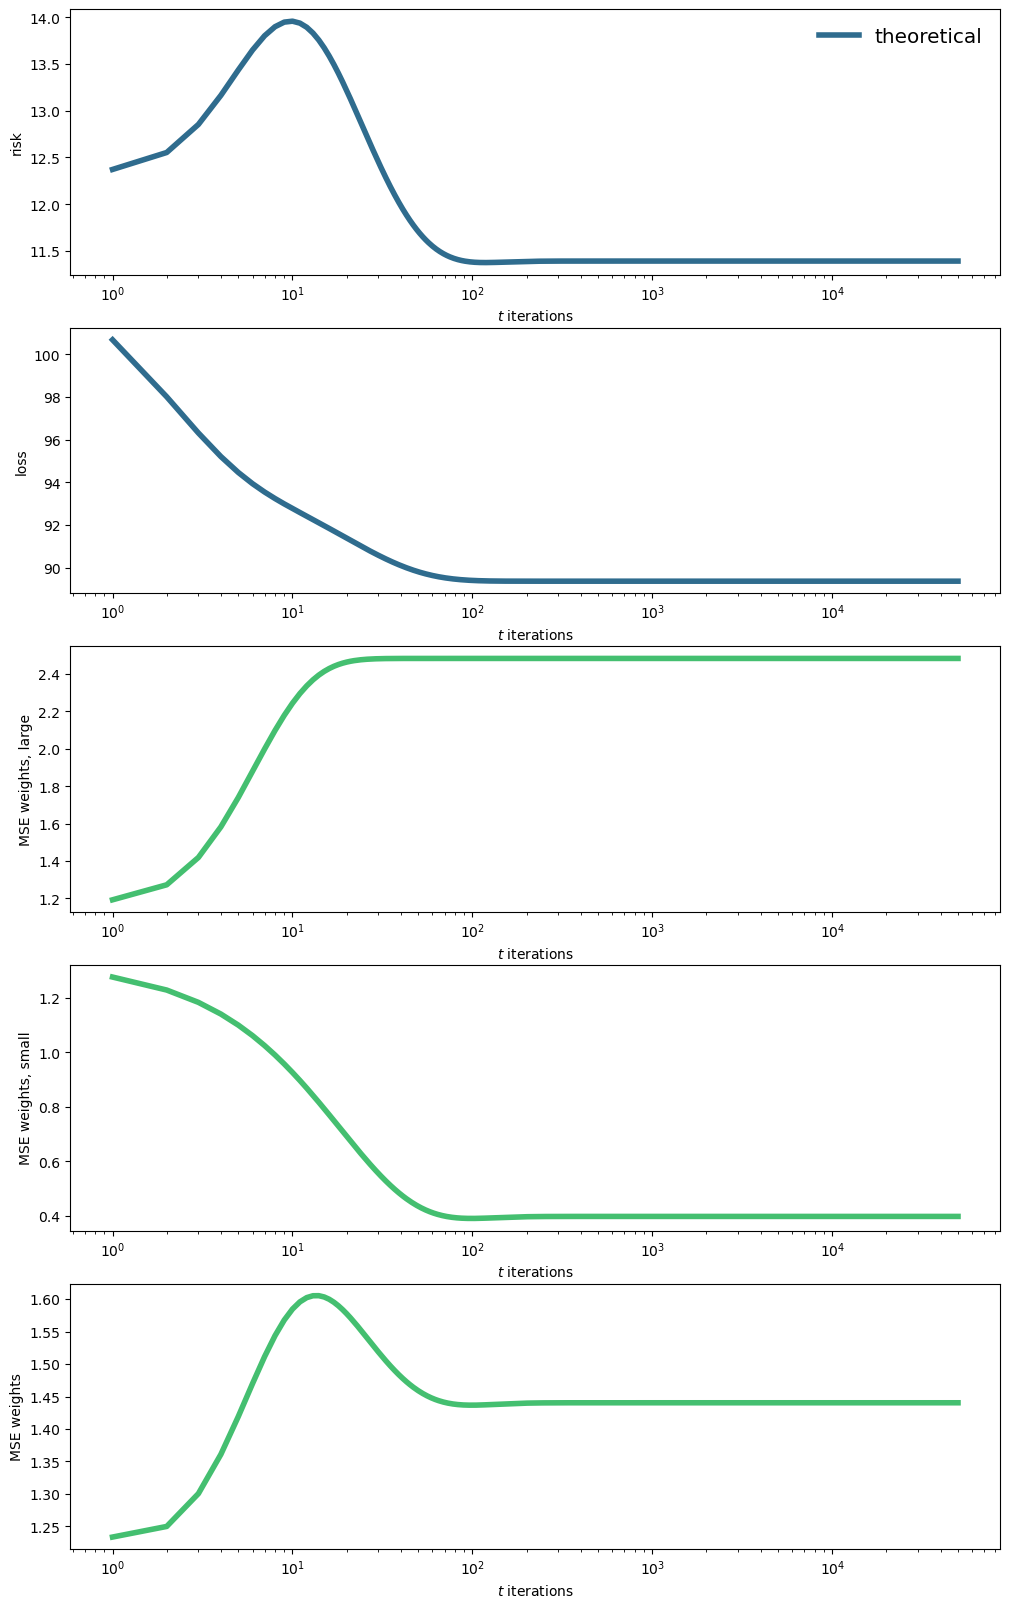

In [69]:
risks = np.array(risks_teo)
losses = np.array(losses_teo)
risks_w = np.row_stack(mse_weights_teo)

cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000), cmap(700/1000)]
labelList = ['empirical', 'theoretical']

extra_axs = 2
fig, ax = plt.subplots(3 + extra_axs, 1, figsize=(12,12 + 4 * extra_axs))

ax[0].set_xscale('log')
ax[0].plot(geo_samples, risks[geo_samples], 
        color=colorList[1], 
        label=labelList[1],
        lw=4)

ax[0].legend(loc=1, bbox_to_anchor=(1, 1), fontsize='x-large',
    frameon=False, fancybox=True, shadow=True, ncol=1)
ax[0].set_ylabel('risk')
ax[0].set_xlabel(r'$t$ iterations')

ax[1].set_xscale('log')
ax[1].plot(geo_samples, losses[geo_samples], 
        color=colorList[1], 
        label=labelList[1],
        lw=4)

ax[1].set_ylabel('loss')
ax[1].set_xlabel(r'$t$ iterations')

p = int(args.dim / 2)
ax[2].set_xscale('log')
ax[2].plot(geo_samples, risks_w[geo_samples, :p].mean(axis=-1), 
        color=colorList[2], 
        label=labelList[1],
        lw=4)

ax[2].set_ylabel('MSE weights, large')
ax[2].set_xlabel(r'$t$ iterations')

ax[3].set_xscale('log')
ax[3].plot(geo_samples, risks_w[geo_samples, p:].mean(axis=-1), 
        color=colorList[2], 
        label=labelList[1],
        lw=4)

ax[3].set_ylabel('MSE weights, small')
ax[3].set_xlabel(r'$t$ iterations')


ax[-1].set_xscale('log')
ax[-1].plot(geo_samples, risks_w[geo_samples, :].mean(axis=-1), 
        color=colorList[2], 
        label=labelList[1],
        lw=4)

ax[-1].set_ylabel('MSE weights')
ax[-1].set_xlabel(r'$t$ iterations')


#ax[0].set_ylim([9, 13])
#ax[1].set_ylim([80, 105])
#ax[2].set_ylim([1, 2.55])
#ax[3].set_ylim([0.35, 1.05])
#ax[4].set_ylim([1, 1.6])


plt.show()

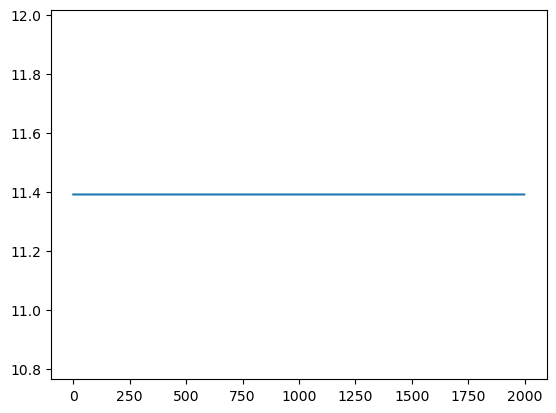

In [46]:
plt.plot(risks_teo[-2000:-1]) #MIIIIIHHH

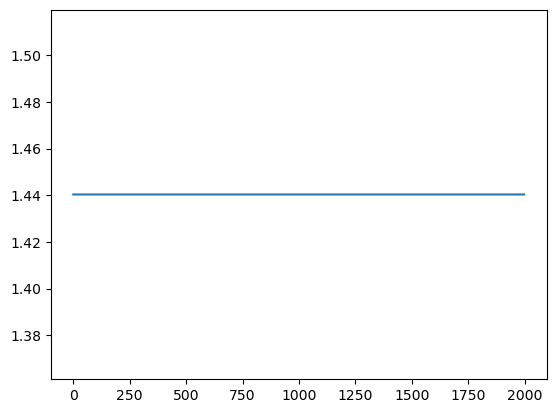

In [47]:
plt.plot(np.row_stack(mse_weights_teo[-2000:-1]).mean(axis=-1))

# VECTOR FIELD

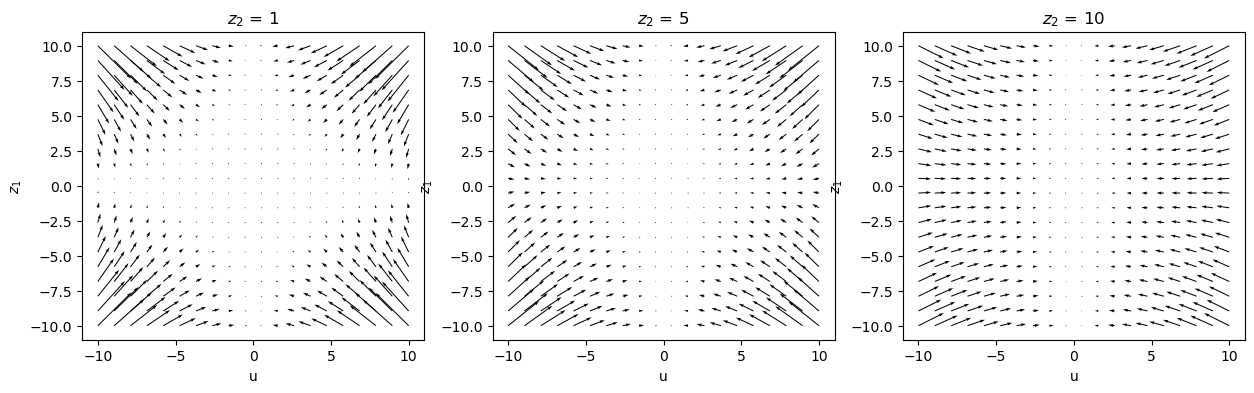

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

v_min, v_max = -10, 10
grid_size = 20
x, y1 = np.meshgrid(np.linspace(v_min, v_max, grid_size),
                    np.linspace(v_min, v_max, grid_size))

# Example 1
y2_1 = 1

eps_0 = ys_t.numpy() - beta @ Xs_t.numpy()
eps = (eps_0 @ np.transpose(Uh)).squeeze()

d1 = (beta[0] - x * y1) * S[0, 0].numpy() + eps[0] * S[0, 0].numpy()**0.5  #St[0, 0].numpy() - x * y1 * S[0, 0].numpy()
d2 = (beta[1] - x * y2_1) * S[0, 1].numpy() + eps[1] * S[0, 1].numpy()**0.5  #St[0, 1].numpy() - x * y2_1 * S[0, 1].numpy()

v = d1 * y1 + d2 * y2_1
w1 = d1 * x

ax[0].quiver(x, y1, v, w1)

ax[0].set_xlabel("u")
ax[0].set_ylabel(fr"$z_1$")
ax[0].set_title(f"$z_2$ = {y2_1}")


# Example 2
y2_2 = 5
d2_2 = (beta[1] - x * y2_2) * S[0, 1].numpy() + eps[1] * S[0, 1].numpy()**0.5  #St[0, 1].numpy() - x * y2_2 * S[0, 1].numpy()

v_2 = d1 * y1 + d2_2 * y2_2

ax[1].quiver(x, y1, v_2, w1)

ax[1].set_xlabel("u")
ax[1].set_ylabel(fr"$z_1$")

ax[1].set_title(f"$z_2$ = {y2_2}")


# Example 3
y2_3 = 10
d2_3 = (beta[1] - x * y2_3) * S[0, 1].numpy() + eps[1] * S[0, 1].numpy()**0.5  #St[0, 1].numpy() - x * y2_2 * S[0, 1].numpy()

v_3 = d1 * y1 + d2_3 * y2_3

ax[2].quiver(x, y1, v_3, w1)

ax[2].set_xlabel("u")
ax[2].set_ylabel(fr"$z_1$")

ax[2].set_title(f"$z_2$ = {y2_3}")


plt.show()

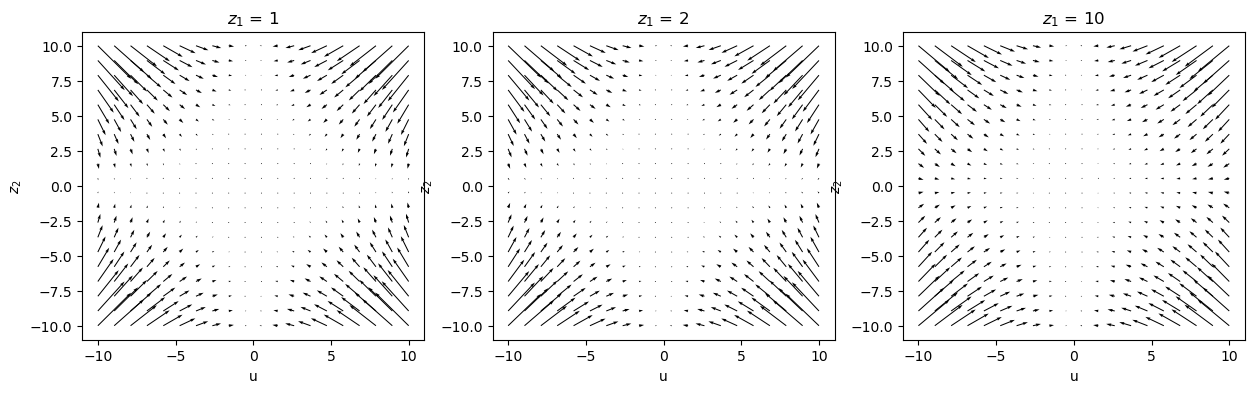

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

v_min, v_max = -10, 10
grid_size = 20
x, y2 = np.meshgrid(np.linspace(v_min, v_max, grid_size),
                    np.linspace(v_min, v_max, grid_size))

# Example 1
y1_1 = 1

d1 = (beta[0] - x * y1_1) * S[0, 0].numpy() + eps[0] * S[0, 0].numpy()**0.5 # St[0, 0].numpy() - x * y2 * S[0, 0].numpy()
d2 = (beta[1] - x * y2) * S[0, 1].numpy() + eps[1] * S[0, 1].numpy()**0.5  #St[0, 1].numpy() - x * y1_1 * S[0, 1].numpy()

v = d1 * y1_1 + d2 * y2
w2 = d2 * x

ax[0].quiver(x, y2, v, w2)

ax[0].set_xlabel("u")
ax[0].set_ylabel(fr"$z_2$")
ax[0].set_title(f"$z_1$ = {y1_1}")


# Example 2
y1_2 = 2
d1_2 = (beta[0] - x * y1_2) * S[0, 0].numpy() + eps[0] * S[0, 0].numpy()**0.5 # St[0, 0].numpy() - x * y1_2 * S[0, 0].numpy()

v_2 = d1_2 * y1_2 + d2 * y2

ax[1].quiver(x, y2, v_2, w2)

ax[1].set_xlabel("u")
ax[1].set_ylabel(fr"$z_2$")

ax[1].set_title(f"$z_1$ = {y1_2}")


# Example 3
y1_3 = 10
d1_3 = (beta[0] - x * y1_2) * S[0, 0].numpy() + eps[0] * S[0, 0].numpy()**0.5 # St[0, 0].numpy() - x * y1_2 * S[0, 0].numpy()

v_3 = d1_3 * y1_3 + d2 * y2

ax[2].quiver(x, y2, v_3, w2)

ax[2].set_xlabel("u")
ax[2].set_ylabel(fr"$z_2$")

ax[2].set_title(f"$z_1$ = {y1_3}")


plt.show()

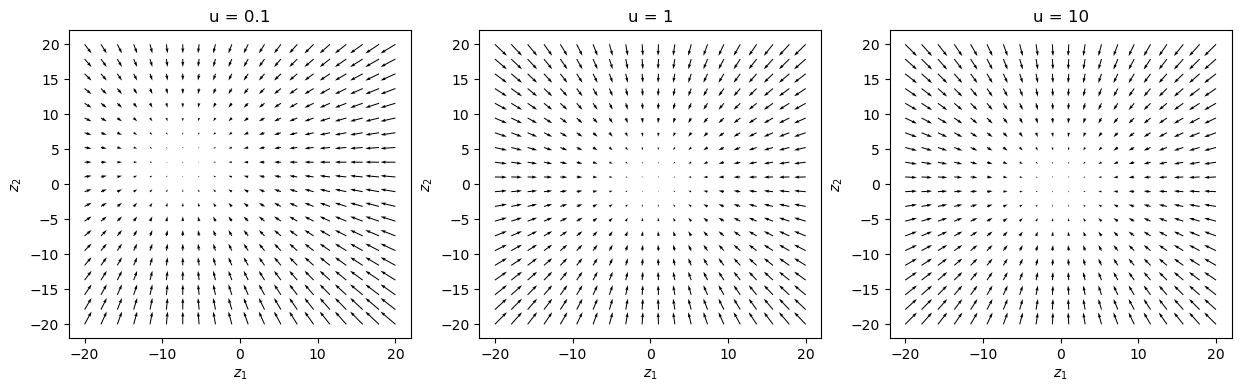

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

v_min, v_max = -20, 20
grid_size = 20
y1, y2 = np.meshgrid(np.linspace(v_min, v_max, grid_size),
                    np.linspace(v_min, v_max, grid_size))


# Example 1
x_1 = 0.1
d1 = (beta[0] - x_1 * y1) * S[0, 0].numpy() + eps[0] * S[0, 0].numpy()**0.5 #St[0, 0].numpy() - x * y1 * S[0, 0].numpy()
d2 = (beta[1] - x_1 * y2) * S[0, 1].numpy() + eps[1] * S[0, 1].numpy()**0.5 #St[0, 1].numpy() - x * y2_1 * S[0, 1].numpy()

w1 = d1 * x_1
w2 = d2 * x_1

ax[0].quiver(y1, y2, w1, w2)

ax[0].set_xlabel(fr"$z_1$")
ax[0].set_ylabel(fr"$z_2$")
ax[0].set_title(f"u = {x_1}")


# Example 2
x_2 = 1
d1_2 = (beta[0] - x_2 * y1) * S[0, 0].numpy() + eps_0[0, 0] * S[0, 0].numpy()**0.5 #St[0, 0].numpy() - x_2 * y1 * S[0, 0].numpy()
d2_2 = (beta[1] - x_2 * y2) * S[0, 1].numpy() + eps_0[0, 1] * S[0, 1].numpy()**0.5 #St[0, 1].numpy() - x_2 * y2 * S[0, 1].numpy()

w1_2 = d1_2 * x_2
w2_2 = d2_2 * x_2

ax[1].quiver(y1, y2, w1_2, w2_2)

ax[1].set_xlabel(fr"$z_1$")
ax[1].set_ylabel(fr"$z_2$")
ax[1].set_title(f"u = {x_2}")


# Example 3
x_3 = 10

d1_3 = (beta[0] - x_3 * y1) * S[0, 0].numpy() + eps[0] * S[0, 0].numpy()**0.5 #St[0, 0].numpy() - x_2 * y1 * S[0, 0].numpy()
d2_3 = (beta[1] - x_3 * y2) * S[0, 1].numpy() + eps[1] * S[0, 1].numpy()**0.5 #St[0, 1].numpy() - x_2 * y2 * S[0, 1].numpy()

w1_3 = d1_3 * x_3
w2_3 = d2_3 * x_3

ax[2].quiver(y1, y2, w1_3, w2_3)

ax[2].set_xlabel(fr"$z_1$")
ax[2].set_ylabel(fr"$z_2$")
ax[2].set_title(f"u = {x_3}")

plt.show()

# För kappa > 1 så rör vi oss främst i z1-riktning, men stort u jämnar ut skillnaderna?
# Vi bör se att vi rör oss längre ifrån de sanna vikterna vid något tillfälle; men vet inte om vi ser det?

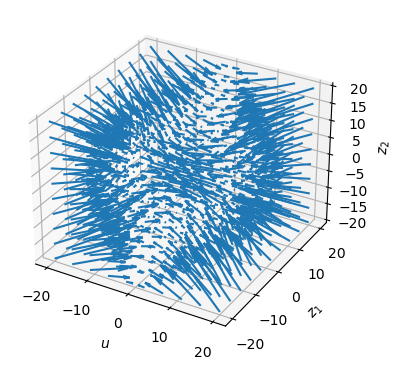

In [51]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')



v_min, v_max = -20, 20
grid_size = 10
x, y1, y2 = np.meshgrid(np.linspace(v_min, v_max, grid_size),
                        np.linspace(v_min, v_max, grid_size),
                        np.linspace(v_min, v_max, grid_size))


d1 = (beta[0] - x * y1) * S[0, 0].numpy() + eps[0] * S[0, 0].numpy()**0.5 #St[0, 0].numpy() - x * y1 * S[0, 0].numpy()
d2 = (beta[1] - x * y2) * S[0, 1].numpy() + eps[1] * S[0, 1].numpy()**0.5 #St[0, 1].numpy() - x * y2 * S[0, 1].numpy()

v = d1 * y1 + d2 * y2
w1 = d1 * x
w2 = d2 * x

ax.quiver(x, y1, y2, v, w1, w2, length=0.0001)

ax.set_xlabel(fr"$u$")
ax.set_ylabel(fr"$z_1$")
ax.set_zlabel(fr"$z_2$")


plt.show()

Text(0.5, 1.0, '$z_2$ = 5')

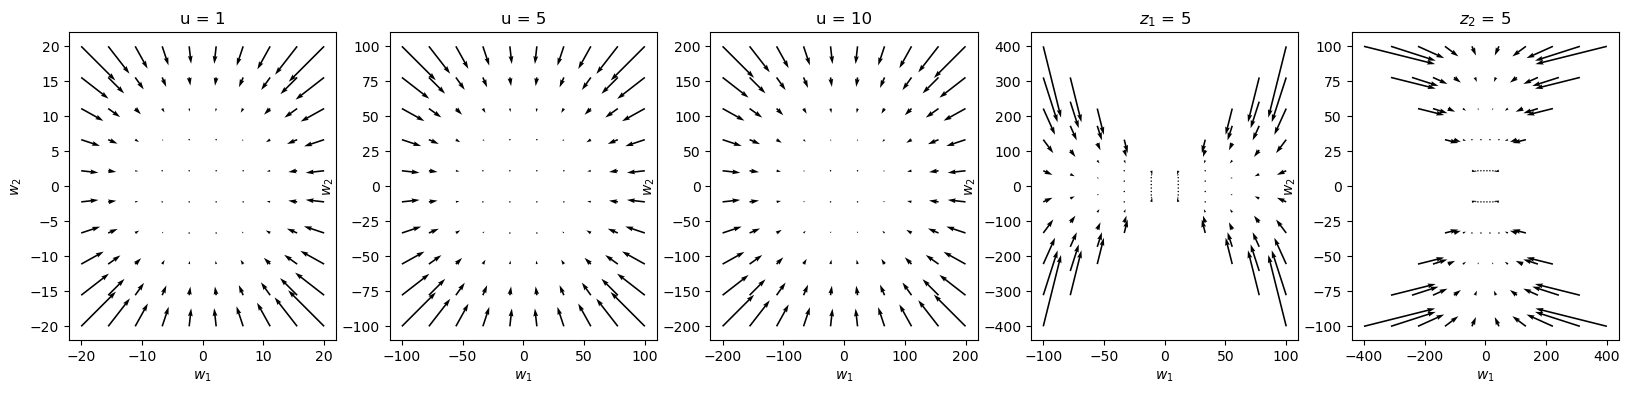

In [52]:
# Wtot

fig, ax = plt.subplots(1, 5, figsize=(20, 4))


# u fixed, #1
v_min, v_max = -20, 20
grid_size = 10
x = 1
y1, y2 = np.meshgrid(np.linspace(v_min, v_max, grid_size),
                     np.linspace(v_min, v_max, grid_size))


d1 = (beta[0] - x * y1) * S[0, 0].numpy() + eps[0] * S[0, 0].numpy()**0.5 #St[0, 0].numpy() - x * y1 * S[0, 0].numpy()
d2 = (beta[1] - x * y2) * S[0, 1].numpy() + eps[1] * S[0, 1].numpy()**0.5 #St[0, 1].numpy() - x * y2 * S[0, 1].numpy()

v = d1 * y1 + d2 * y2
w1 = d1 * x
w2 = d2 * x

# Total weights 
p1 = x * y1
p2 = x * y2

q1 = v * y1 + w1 * x
q2 = v * y2 + w2 * x

ax[0].quiver(p1, p2, q1, q2)

ax[0].set_xlabel(fr"$w_1$")
ax[0].set_ylabel(fr"$w_2$")
ax[0].set_title(f"u = {x}")


# u fixed, #2
v_min, v_max = -20, 20
grid_size = 10
x = 5
y1, y2 = np.meshgrid(np.linspace(v_min, v_max, grid_size),
                     np.linspace(v_min, v_max, grid_size))


d1 = (beta[0] - x * y1) * S[0, 0].numpy() + eps[0] * S[0, 0].numpy()**0.5 #St[0, 0].numpy() - x * y1 * S[0, 0].numpy()
d2 = (beta[1] - x * y2) * S[0, 1].numpy() + eps[1] * S[0, 1].numpy()**0.5 #St[0, 1].numpy() - x * y2 * S[0, 1].numpy()

v = d1 * y1 + d2 * y2
w1 = d1 * x
w2 = d2 * x

# Total weights 
p1 = x * y1
p2 = x * y2

q1 = v * y1 + w1 * x
q2 = v * y2 + w2 * x

ax[1].quiver(p1, p2, q1, q2)

ax[1].set_xlabel(fr"$w_1$")
ax[1].set_ylabel(fr"$w_2$")
ax[1].set_title(f"u = {x}")


# u fixed, #3
v_min, v_max = -20, 20
grid_size = 10
x = 10
y1, y2 = np.meshgrid(np.linspace(v_min, v_max, grid_size),
                     np.linspace(v_min, v_max, grid_size))


d1 = (beta[0] - x * y1) * S[0, 0].numpy() + eps[0] * S[0, 0].numpy()**0.5 #St[0, 0].numpy() - x * y1 * S[0, 0].numpy()
d2 = (beta[1] - x * y2) * S[0, 1].numpy() + eps[1] * S[0, 1].numpy()**0.5 #St[0, 1].numpy() - x * y2 * S[0, 1].numpy()

v = d1 * y1 + d2 * y2
w1 = d1 * x
w2 = d2 * x

# Total weights 
p1 = x * y1
p2 = x * y2

q1 = v * y1 + w1 * x
q2 = v * y2 + w2 * x

ax[2].quiver(p1, p2, q1, q2)

ax[2].set_xlabel(fr"$w_1$")
ax[2].set_ylabel(fr"$w_2$")
ax[2].set_title(f"u = {x}")


# z_1 fixed 
y1 = 5
x, y2 = np.meshgrid(np.linspace(v_min, v_max, grid_size),
                    np.linspace(v_min, v_max, grid_size))


d1 = (beta[0] - x * y1) * S[0, 0].numpy() + eps[0] * S[0, 0].numpy()**0.5 #St[0, 0].numpy() - x * y1 * S[0, 0].numpy()
d2 = (beta[1] - x * y2) * S[0, 1].numpy() + eps[1] * S[0, 1].numpy()**0.5 #St[0, 1].numpy() - x * y2 * S[0, 1].numpy()

v = d1 * y1 + d2 * y2
w1 = d1 * x
w2 = d2 * x

# Total weights 
p1 = x * y1
p2 = x * y2

q1 = v * y1 + w1 * x
q2 = v * y2 + w2 * x

ax[3].quiver(p1, p2, q1, q2)

ax[3].set_xlabel(fr"$w_1$")
ax[3].set_ylabel(fr"$w_2$")
ax[3].set_title(f"$z_1$ = {y1}")



# z_2 fixed 
y2 = 5
x, y1 = np.meshgrid(np.linspace(v_min, v_max, grid_size),
                    np.linspace(v_min, v_max, grid_size))


d1 = (beta[0] - x * y1) * S[0, 0].numpy() + eps[0] * S[0, 0].numpy()**0.5 #St[0, 0].numpy() - x * y1 * S[0, 0].numpy()
d2 = (beta[1] - x * y2) * S[0, 1].numpy() + eps[1] * S[0, 1].numpy()**0.5 #St[0, 1].numpy() - x * y2 * S[0, 1].numpy()

v = d1 * y1 + d2 * y2
w1 = d1 * x
w2 = d2 * x

# Total weights 
p1 = x * y1
p2 = x * y2

q1 = v * y1 + w1 * x
q2 = v * y2 + w2 * x

ax[4].quiver(p1, p2, q1, q2)

ax[4].set_xlabel(fr"$w_1$")
ax[4].set_ylabel(fr"$w_2$")
ax[4].set_title(f"$z_2$ = {y2}")

Text(0.5, 1.0, '$z_2$ = 5')

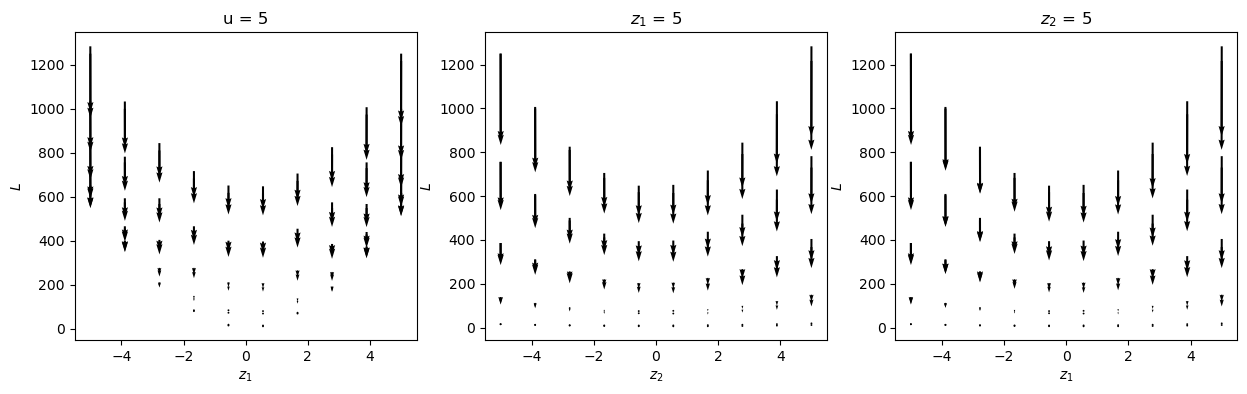

In [53]:
# MSE

fig, ax = plt.subplots(1, 3, figsize=(15, 4))


# u fixed 
v_min, v_max = -5, 5
grid_size = 10
x = 5
y1, y2 = np.meshgrid(np.linspace(v_min, v_max, grid_size),
                     np.linspace(v_min, v_max, grid_size))


d1 = (beta[0] - x * y1) * S[0, 0].numpy() + eps[0] * S[0, 0].numpy()**0.5 #St[0, 0].numpy() - x * y1 * S[0, 0].numpy()
d2 = (beta[1] - x * y2) * S[0, 1].numpy() + eps[1] * S[0, 1].numpy()**0.5 #St[0, 1].numpy() - x * y2 * S[0, 1].numpy()

v = d1 * y1 + d2 * y2
w1 = d1 * x
w2 = d2 * x

# Total weights 
p1 = x * y1
p2 = x * y2

q1 = v * y1 + w1 * x
q2 = v * y2 + w2 * x

r = (beta[0] - p1)**2 + (beta[1] - p2)**2 

beta_v = beta @ np.transpose(V)  # TODO: do all other equations assume V=I or does it not matter?
rm = (x * y1 - beta_v[0]) * q1 + (x * y2 - beta_v[1]) * q2 

ax[0].quiver(y1, r, w1, rm)

ax[0].set_xlabel(fr"$z_1$")
ax[0].set_ylabel(fr"$L$")
ax[0].set_title(f"u = {x}")


# z_1 fixed 
y1 = 5
x, y2 = np.meshgrid(np.linspace(v_min, v_max, grid_size),
                    np.linspace(v_min, v_max, grid_size))


d1 = (beta[0] - x * y1) * S[0, 0].numpy() + eps[0] * S[0, 0].numpy()**0.5 #St[0, 0].numpy() - x * y1 * S[0, 0].numpy()
d2 = (beta[1] - x * y2) * S[0, 1].numpy() + eps[1] * S[0, 1].numpy()**0.5 #St[0, 1].numpy() - x * y2 * S[0, 1].numpy()

v = d1 * y1 + d2 * y2
w1 = d1 * x
w2 = d2 * x

# Total weights 
p1 = x * y1
p2 = x * y2

q1 = v * y1 + w1 * x
q2 = v * y2 + w2 * x

r = (beta[0] - p1)**2 + (beta[1] - p2)**2 # Tar V ut sig självt?

beta_v = beta @ np.transpose(V)  # TODO: do all other equations assume V=I or does it not matter?
rm = (x * y1 - beta_v[0]) * q1 + (x * y2 - beta_v[1]) * q2 

ax[1].quiver(y2, r, w2, rm)

ax[1].set_xlabel(fr"$z_2$")
ax[1].set_ylabel(fr"$L$")
ax[1].set_title(f"$z_1$ = {y1}")



# z_2 fixed 
y2 = 5
x, y1 = np.meshgrid(np.linspace(v_min, v_max, grid_size),
                    np.linspace(v_min, v_max, grid_size))


d1 = (beta[0] - x * y1) * S[0, 0].numpy() + eps[0] * S[0, 0].numpy()**0.5 #St[0, 0].numpy() - x * y1 * S[0, 0].numpy()
d2 = (beta[1] - x * y2) * S[0, 1].numpy() + eps[1] * S[0, 1].numpy()**0.5 #St[0, 1].numpy() - x * y2 * S[0, 1].numpy()

v = d1 * y1 + d2 * y2
w1 = d1 * x
w2 = d2 * x

# Total weights 
p1 = x * y1
p2 = x * y2

q1 = v * y1 + w1 * x
q2 = v * y2 + w2 * x

r = (beta[0] - p1)**2 + (beta[1] - p2)**2 # Tar V ut sig självt?

beta_v = beta @ np.transpose(V)  # TODO: do all other equations assume V=I or does it not matter? Se logg 22/11 09:42.
rm = (x * y1 - beta_v[0]) * q1 + (x * y2 - beta_v[1]) * q2 

ax[2].quiver(y1, r, w1, rm)

ax[2].set_xlabel(fr"$z_1$")
ax[2].set_ylabel(fr"$L$")
ax[2].set_title(f"$z_2$ = {y2}")

